In [572]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monalisa-by-picasso/Mona Lisa.jpg
/kaggle/input/monalisa-by-picasso/Picasso.jpg


In [573]:

import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [574]:
content_path='/kaggle/input/monalisa-by-picasso/Mona Lisa.jpg'
style_path = '/kaggle/input/monalisa-by-picasso/Picasso.jpg'

In [575]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image = image.resize(
        (round(image.size[0]*factor), round(image.size[1]*factor)),
        Image.Resampling.LANCZOS
    )
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                               #batch of single image 
    
    return im_array

In [576]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [577]:
content = load_file(content_path)
style = load_file(style_path)

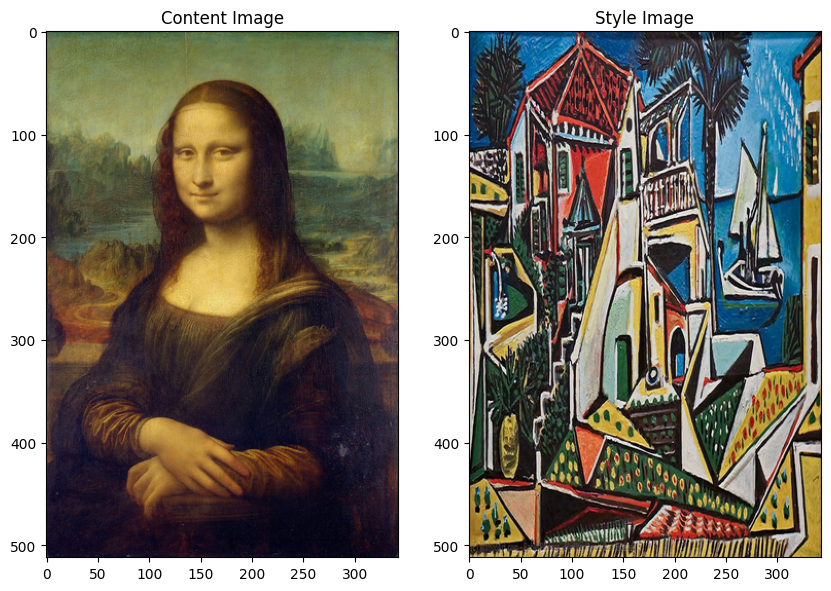

In [578]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [579]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [580]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [581]:
im=img_preprocess(content_path)

In [582]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [583]:
def get_model():
    # Layer-layer yang akan diambil untuk style dan content
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']
    
    # Buat input tensor
    input_tensor = tf.keras.Input(shape=(None, None, 3))  # input image of any size
    preprocessed_input = vgg19.preprocess_input(input_tensor)

    # Ambil model VGG19 tanpa top layer
    vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=preprocessed_input)
    vgg.trainable = False

    # Ambil output dari layer yang diperlukan
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]

    # Bangun ulang model dengan input baru dan output yang dipilih
    model = Model(inputs=input_tensor, outputs=outputs)
    return model

In [584]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [585]:
model=get_model()
model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_141        │ (None, None,      │          0 │ input_layer_94[0… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_142        │ (None, None,      │          0 │ input_layer_94[0… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_143        │ (None, None,      │          0 │ input_layer_94[0… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_47 (Stack)    │ (None, None,      │          0 │ get_item_141[0][… │
│                     │ None, 3)          │            │ get_item_142[0][… │
│                     │                   │            │ get_item_143[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_47 (Add)        │ (None, None,      │          0 │ stack_47[0][0]    │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ add_47[0][0]      │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, None,      │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, None,      │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, None,      │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, None,      │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

In [586]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

In [587]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [588]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    

In [589]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

In [590]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

In [591]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [592]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [593]:
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_95 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [594]:
def run_style_transfer(content_path,style_path,epochs=10000,content_weight=1e2, style_weight=1e4):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

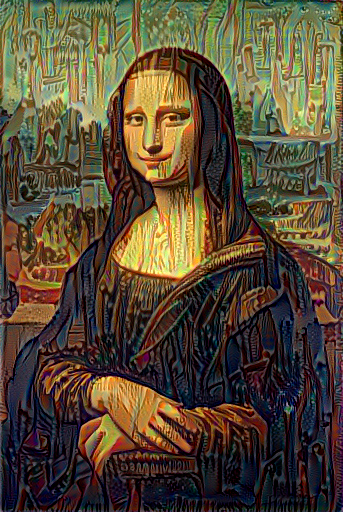

Epoch: 9995
Total loss: 2.9826e+13, style loss: 2.9826e+13, content loss: 8.4179e+05, 


In [595]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=10000)


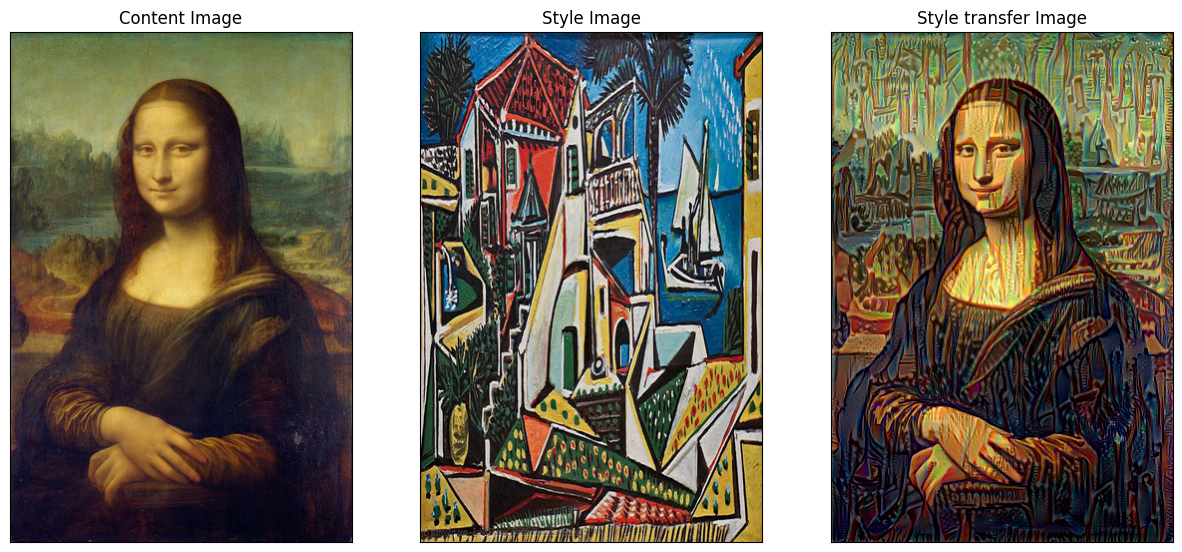

In [596]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()